In [1]:
import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)

import os
import sys
import dataclasses
from dataclasses import dataclass, field
from typing import Callable, Dict, Optional
from tqdm import tqdm
import json
import numpy as np
from pathlib import Path
import random
import torch
import pandas as pd
import hydra
import pickle
import joblib
import yaml

from utils.utils_wandb import init_wandb, wandb

from ue4nlp.transformers_cached import (
    ElectraForSequenceClassificationCached,
    BertForSequenceClassificationCached,
)
from ue4nlp.dropconnect_mc import (
    LinearDropConnectMC,
    activate_mc_dropconnect,
    convert_to_mc_dropconnect,
    hide_dropout,
)
from ue4nlp.dropout_mc import DropoutMC, activate_mc_dropout, convert_to_mc_dropout
from ue4nlp.dropout_dpp import DropoutDPP, DropoutDPP_v2
from ue4nlp.text_classifier import TextClassifier
from ue4nlp.electra_duq_model import ElectraForSequenceClassificationDUQ
from ue4nlp.bert_sngp_model import (
    SNGPBertForSequenceClassificationCached, 
    SNGPElectraForSequenceClassificationCached,
)
from utils.utils_heads import ElectraClassificationHeadCustom

from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    EvalPrediction,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    set_seed,
    ElectraForSequenceClassification,
)
from datasets import load_metric, load_dataset, Dataset

from utils.utils_dropout import set_last_dropout, get_last_dropout, set_last_dropconnect
import alpaca_calibrator as calibrator
from ue4nlp.utils_sngp import SNGPTrainer
import sbermed.experimental.ainesterov.symptom_checker.src.top3 as models

import logging

import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='3'


log = logging.getLogger(__name__)


task_to_keys = {
    "symptoms": ("body", None)
}

In [2]:
#%env CUDA_VISIBLE_DEVICES=1

In [3]:
base_df = pd.read_csv('/home/avazhentsev/data/tmp/data/diseasecases_for_msk_body.csv')
base_df.body.fillna('', inplace=True)
keep_mask = ~base_df.duplicated(subset=['body']).values
df_test = base_df.iloc[keep_mask, :]

train_dataset = None #Dataset.from_pandas(df_train)
eval_dataset = Dataset.from_pandas(df_test.sample(frac=1))

In [4]:
def update_config_symptom_checker(conf, device='cuda'):
    for key in conf.keys():
        if type(conf[key]) is dict:
            for sub_key in conf[key]:
                if 'path' in sub_key:
                    conf[key][sub_key] = '/home/avazhentsev/data/tmp' + conf[key][sub_key][2:]
        elif 'path' in key:
            conf[key] = '/home/avazhentsev/data/tmp' + conf[key][2:]
    conf['device'] = device
    return conf

In [5]:
label_to_id = joblib.load('/home/avazhentsev/data/tmp/data/top3/l2i_niar_megi.pkl')
with open('/home/avazhentsev/data/sbermed/experimental/ainesterov/symptom_checker/src/test_config.yaml', 'r') as f:
    conf = yaml.safe_load(f)

conf = update_config_symptom_checker(conf)

In [6]:
estimator = models.Estimator(conf['top3'], conf['device'])
model, tokenizer = estimator.evaluator, estimator.tokenizer

You are using a model of type longformer to instantiate a model of type bert. This is not supported for all configurations of models and can yield errors.


In [7]:
sentence1_key, sentence2_key = task_to_keys['symptoms']
padding = "max_length"
max_seq_length = estimator.max_seq_len

def preprocess_function(examples):
    # Tokenize the texts
    args = (
        (examples[sentence1_key],)
        if sentence2_key is None
        else (examples[sentence1_key], examples[sentence2_key])
    )
    result = {'input_ids': [],
              'token_type_ids': [],
              'attention_mask': []
             }
    
    for text in examples[sentence1_key]:
        encoded = estimator._encode(text)
        result['input_ids'].append(encoded[0].numpy().tolist())
        result['attention_mask'].append(encoded[1].numpy().tolist())
        result['token_type_ids'].append([0]*max_seq_length) 

    label_column_name = 'original_mkb_code' if 'original_mkb_code' in examples.keys() else "mkb_code"
    # Map labels to IDs (not necessary for GLUE tasks)
    if label_to_id is not None and label_column_name in examples:
        result["label"] = [
            (label_to_id[l] if l != -1 else -1) for l in examples[label_column_name]
        ]
    return result

    
eval_dataset = eval_dataset.map(
    preprocess_function,
    batched=True,
    num_proc=1
)
eval_dataset.set_format(columns=['attention_mask', 'input_ids', 'token_type_ids', 'label'])

In [8]:
metric = load_metric(
        "accuracy", keep_in_memory=True,
    )
def compute_metrics(is_regression, metric, p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.squeeze(preds) if is_regression else np.argmax(preds, axis=1)

    result = metric.compute(predictions=preds, references=p.label_ids)
    if len(result) > 1:
        result["combined_score"] = np.mean(list(result.values())).item()

    return result

is_regression = False
metric_fn = lambda p: compute_metrics(is_regression, metric, p)
    
trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=metric_fn
)

In [9]:
tagger = TextClassifier(
        model, tokenizer, trainer=trainer
    )

In [10]:
preds, probs = tagger.predict(eval_dataset, calibrate=False)

In [11]:
from sklearn.metrics import classification_report

print(classification_report(eval_dataset["label"], preds))

/home/avazhentsev/data/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.27      0.25      0.26      1178
           1       0.58      0.41      0.48      9893
           2       0.00      0.00      0.00       874
           3       0.33      0.56      0.41      2857
           4       0.03      0.07      0.04       736
           5       0.60      0.42      0.49      1084
           6       0.35      0.34      0.35      1265
           7       0.00      0.00      0.00       933
           8       0.39      0.29      0.33       269
           9       0.58      0.30      0.40      1633
          10       0.55      0.29      0.38       280
          11       0.48      0.42      0.45      1385
          12       0.58      0.40      0.47      4081
          13       0.38      0.09      0.15      1189
          14       0.34      0.27      0.30       909
          15       0.00      0.00      0.00       543
          16       0.00      0.00      0.00      2132
          17       0.00    

In [12]:
true_pred = 0
for example, label in tqdm(zip(probs, eval_dataset["label"])):
    top3 = np.argsort(example)[-3:]
    if label in top3:
        true_pred+=1
print(1.*true_pred/probs.shape[0])

1728529it [00:31, 55207.19it/s]

0.6184883215728518


In [2]:
from pathlib import Path
import numpy as np
import os
from tqdm import tqdm
from sklearn.metrics import roc_auc_score
import json
import orjson as json
import re

from ue4nlp.ue_scores import *
from ue4nlp.ue_variation_ratio import ue_variation_ratio

from utils.plot_error_detection import draw_charts
from utils.plot_error_detection import create_chart_data

import matplotlib.pyplot as plt
from utils.plot_error_detection import plot_error_detection, plot_rejection_curve_aucs


def plot_roc_auc(res_path):
    with open(Path(res_path) / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())
    
    plot_error_detection(np.asarray(model_outputs['probabilities']), 
                         np.asarray(model_outputs['true_labels']), 
                         np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2))
    
def plot_rejection_curves(res_path):
    with open(Path(res_path) / 'dev_inference.json') as f:
        model_outputs = json.loads(f.read())
    
    plot_rejection_curve_aucs(np.asarray(model_outputs['probabilities']), 
                              np.asarray(model_outputs['true_labels']), 
                              np.asarray(model_outputs['sampled_probabilities']).transpose(1, 0, 2),
                              np.asarray(model_outputs['answers']), )

In [18]:
import tqdm

run_dir = '../../sbermed_ue/uncertainty-estimation/workdir/results/mc_symptoms_train_63/symptoms/MC/last/10/101'
sampled_probabilities = []
for seed in tqdm.tqdm(['17', '42', '51', '91', '101']):
    with open(Path(f'{run_dir}/{seed}') / "dev_inference.json") as f:
        model_outputs = json.loads(f.read())
    print(np.asarray(model_outputs['sampled_probabilities']).shape)
    sampled_probabilities.append(np.asarray(model_outputs["probabilities"]).copy())
    
    probabilities = np.asarray(model_outputs['probabilities'])
    labels = np.asarray(model_outputs['true_labels'])
    
    predictions = np.argmax(probabilities, axis=-1)
    errors = (labels != predictions).astype("uint8")
    print(errors[:10])
    print(probabilities[:2, :2])
    max_prob = 1.0 - np.max(probabilities, axis=-1)
    print(roc_auc_score(errors, max_prob))

  0%|          | 0/5 [00:00<?, ?it/s]

(10, 18427, 265)


 20%|██        | 1/5 [00:11<00:45, 11.37s/it]

[1 1 1 1 1 1 0 0 1 1]
[[7.06961437e-04 9.45837994e-04]
 [1.15849201e-04 2.39721976e-05]]
0.7336562546668878
(10, 18427, 265)
[1 1 1 1 1 1 1 0 1 1]
[[0.00080715 0.00042487]
 [0.00019452 0.00010121]]


 40%|████      | 2/5 [00:29<00:40, 13.54s/it]

0.7412976140621546
(10, 18427, 265)


 60%|██████    | 3/5 [00:41<00:25, 12.89s/it]

[1 1 1 0 1 1 1 0 1 1]
[[1.09329179e-03 8.07381992e-04]
 [7.03759142e-05 3.92955517e-05]]
0.7348187410596689
(10, 18427, 265)


 80%|████████  | 4/5 [00:52<00:12, 12.48s/it]

[1 1 1 0 1 1 1 0 1 1]
[[1.16785965e-03 6.75274234e-04]
 [7.63241187e-05 5.36365405e-05]]
0.7435106060813003
(10, 18427, 265)


100%|██████████| 5/5 [01:04<00:00, 12.82s/it]

[1 1 1 1 1 1 0 0 1 1]
[[1.38389552e-03 7.42173230e-04]
 [1.88188889e-04 7.73481734e-05]]
0.733680334925656


In [19]:
probabilities = np.asarray(model_outputs['probabilities'])
labels = np.asarray(model_outputs['true_labels'])
sampled_probabilities = np.asarray(sampled_probabilities).transpose(1, 0, 2)

In [20]:
methods = {
        "bald": bald,
        "var_ratio": var_ratio,
        "entropy": mean_entropy,
        "sampled_max_prob": sampled_max_prob,
        "variance": probability_variance,
}

In [21]:
sampled_probabilities.shape

(18427, 5, 265)

In [22]:
predictions = np.argmax(probabilities, axis=-1)
errors = (labels != predictions).astype("uint8")

results = {}
for name, method_function in methods.items():
    ue_scores = method_function(sampled_probabilities)
    results[name] = roc_auc_score(errors, ue_scores)

max_prob = 1.0 - np.max(probabilities, axis=-1)
results["max_prob"] = roc_auc_score(errors, max_prob)
results

{'bald': 0.6866625372420074,
 'var_ratio': 0.6811103883159744,
 'entropy': 0.7395306188676475,
 'sampled_max_prob': 0.7508176330340166,
 'variance': 0.6468919133942168,
 'max_prob': 0.733680334925656}

bald: 0.6866625372420074
var_ratio: 0.6811103883159744
entropy: 0.7395306188676475
sampled_max_prob: 0.7508176330340166
variance: 0.6468919133942168
max_prob: 0.733680334925656


array([0.68666254, 0.68111039, 0.73953062, 0.75081763, 0.64689191,
       0.73368033])

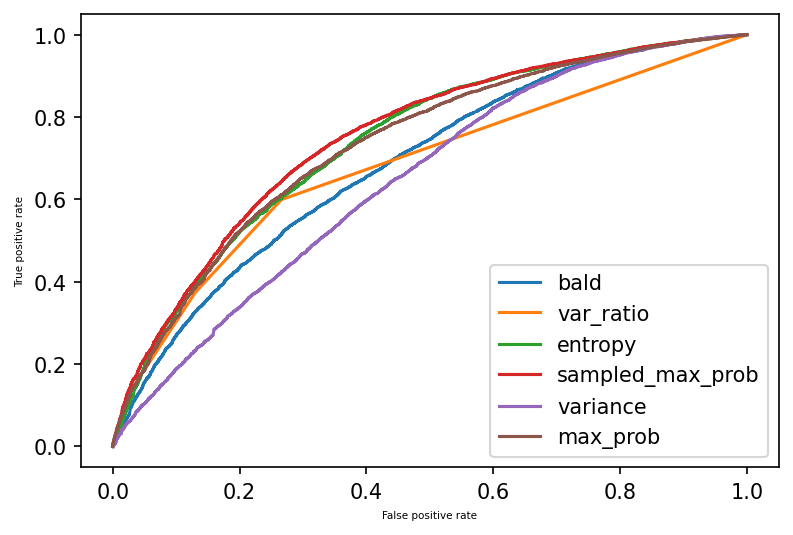

In [23]:
plot_error_detection(probabilities, 
                     labels, 
                     sampled_probabilities)